(911, 1)


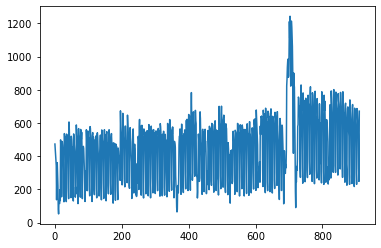

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
class Mydataseries(Dataset):
    def __init__(self,input_data,tw):
        self.train_seq1 = []
        self.train_label1 = []
        self.L = len(input_data)
        print(self.L)
        for i in range(self.L-tw):
            train_seq = input_data[i:i+tw]
            train_label = input_data[i+tw:i+tw+1]
            self.train_seq1.append(train_seq)
            self.train_label1.append(train_label)
    def __len__(self):
        return len(self.train_seq1)
    def __getitem__(self,idx):
        return self.train_seq1[idx],self.train_label1[idx]

jiangda =pd.read_csv("datacount7.csv", usecols=[1])
plt.plot(jiangda)
print(jiangda.shape)

In [2]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)
# invert differenced v|alue
def inverse_difference(history, yhat):
	return history+yhat

In [3]:
jiangda2 = jiangda['y'].values.astype(float)
diff = difference(jiangda2, 1)

In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(diff.to_numpy().reshape(-1, 1))

In [5]:
data_scaled = torch.FloatTensor(data_scaled).view(-1)
y = jiangda2[-32:-1].reshape(-1, 1)
result = jiangda2[-31:]
result = result.reshape(-1, 1)

In [8]:
train_window = 7
test_data_size = 31+train_window
train_data = data_scaled[:-test_data_size]
test_data = data_scaled[-test_data_size:]
mydataseries = Mydataseries(train_data,train_window)
mydataseriestest = Mydataseries(test_data,train_window)
trainseq1 = DataLoader(dataset=mydataseries, batch_size=1, shuffle=True, num_workers=0, drop_last=False)
testseq2 = DataLoader(dataset=mydataseriestest, batch_size=1,num_workers=0,drop_last=False)

872
38


In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, batch_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, 1)

        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        
    def forward(self, input_seq, hidden_cell):
        B, C = input_seq.shape
        input_seq = input_seq.reshape(B, C , -1)
        input_seq = input_seq.permute(1, 0 ,2)
        lstm_out, hidden_cell = self.lstm(input_seq, hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions[-1]
    
model = LSTM().to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
epochd = 15
for i in range(epochs):
    for train_seq,train_label in trainseq1:
        train_seq, train_label = train_seq.to(device), train_label.to(device)
        optimizer.zero_grad()
        hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                       torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(train_seq, hidden_cell)
        single_loss = loss_function(y_pred, train_label)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00111874
epoch:   1 loss: 0.0011187375


In [ ]:
model.eval()

In [ ]:
pred = []
from itertools import chain
for (train_seq,train_label) in testseq2:
    train_seq, train_label = train_seq.to(device), train_label.to(device)
    train_label = list(chain.from_iterable(train_label.data.tolist()))
    with torch.no_grad():
        hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                       torch.zeros(1, 1, model.hidden_layer_size).to(device))
        y_pred = model(train_seq,hidden_cell)
        y_pred = list(chain.from_iterable(y_pred.data.tolist()))
        y_pred = np.array(y_pred)
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
        pred.extend(y_pred)
        
pred = np.array(pred)
result = np.array(result)

In [ ]:
yhat = inverse_difference(pred,y)
yhat

In [ ]:
r_squared = r2_score(yhat,result)
print(f"R方值：{r_squared}")

mae = mean_absolute_error(yhat,result)
print(f"平均绝对误差（MAE）：{mae}")

rmse = np.sqrt(mean_squared_error(yhat,result))
print(f"均方根误差（RMSE）：{rmse}")
forecast_predictions = np.squeeze(yhat)
act = np.sum(result)           
.
m  = np.abs(result - yhat)
gapsum = np.sum(m)
gap = gapsum/31
gapratio = gapsum/act
print(gapsum,gap,gapratio)